In [10]:
# !ls
# !python3.10 -m pip install nbqa pylint
# !conda activate tf

In [33]:
import keras
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

from keras import Sequential
from keras.datasets import mnist
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.layers import Dense, Input, Conv2D
from keras.callbacks import History
# from keras.callbacks import LambdaCallback, ModelCheckpoint


EPOCHS: int = 2
BATCH_SIZE: int = 128
LOAD_MODEL: bool = False
MODEL_FILENAME: str = 'numbers_detection.h5'

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# GET DATASETS

def get_numbers_data() -> tuple[tuple[np.ndarray, np.ndarray], tuple[np.ndarray, np.ndarray]]:
    return mnist.load_data()

(train_dataset, train_dataset_marks), (test_dataset, test_dataset_marks) = get_numbers_data()

print(f'{len(train_dataset)=}')
print(f'{len(train_dataset_marks)=}')
print(f'{len(test_dataset)=}')
print(f'{len(test_dataset_marks)=}')


len(train_dataset)=60000
len(train_dataset_marks)=60000
len(test_dataset)=10000
len(test_dataset_marks)=10000


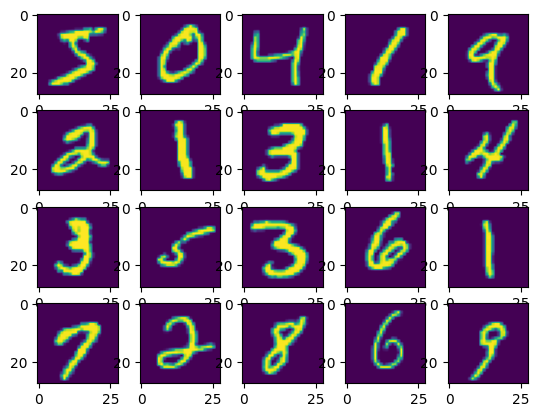

In [3]:
# SHOW EXAMPLES

def show_example_data(train_data: list[np.ndarray], columns: int = 4, rows: int = 5) -> None:
    figure = plt.figure(
        # figsize=(8, 8)
    )

    for i, img in enumerate(train_data[:columns*rows], start=1):
        figure.add_subplot(columns, rows, i)
        plt.imshow(img)
        
show_example_data(train_dataset)

In [4]:
# PREPARE DATASET

def prepare_data(raw_data: np.ndarray[np.ndarray]) -> np.ndarray[np.ndarray]:
    ret = raw_data.astype("float32") / 255
    ret = ret.reshape(-1, 28*28)
    # for i, img in enumerate(raw_data):
    #     img = img.astype(np.float32) / 255.0
    #     img = img.reshape((img.shape[0]*img.shape[1], )) # (784, ) shape
    #     ret[i] = img
        
    return ret
    
    
train_prepared_dataset = prepare_data(train_dataset)
test_prepared_dataset = prepare_data(test_dataset)
train_prepared_dataset_marks = keras.utils.to_categorical(train_dataset_marks, 10)
test_prepared_dataset_marks = keras.utils.to_categorical(test_dataset_marks, 10)
input_shape: tuple[int] = train_prepared_dataset[0].shape

print(f'{len(train_prepared_dataset)=}, {len(test_prepared_dataset)=}')
print(f'img with number => {train_dataset_marks[0]} with size {train_prepared_dataset[0].size} and {train_prepared_dataset[0].shape} linear shape')
print(f'{input_shape=}')

len(train_prepared_dataset)=60000, len(test_prepared_dataset)=10000
img with number => 5 with size 784 and (784,) linear shape
input_shape=(784,)


model successfully created => <keras.engine.sequential.Sequential object at 0x7f1730362860>
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 800)               628000    
                                                                 
 dense_1 (Dense)             (None, 200)               160200    
                                                                 
 dense_2 (Dense)             (None, 10)                2010      
                                                                 
Total params: 790,210
Trainable params: 790,210
Non-trainable params: 0
_________________________________________________________________


2023-03-11 14:15:21.511769: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-11 14:15:21.515177: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-11 14:15:21.515566: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-11 14:15:21.515839: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_nod

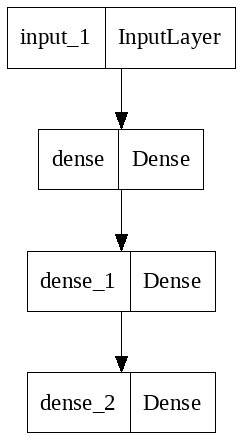

In [5]:
# MODEL

# Input - Входящий слой
# Dense - Полносвязный слой 
# Rectified linear unit (ReLU) — усеченное линейное преобразование
# Softmax function — функция мягкого максимума, софтмакс

model = keras.models.load_model(MODEL_FILENAME) if LOAD_MODEL is True else Sequential([
    Input(shape=input_shape), 
    Dense(800, activation='relu'), 
    Dense(200, activation='relu'),
    Dense(10, activation='softmax')
])

print(f'model successfully created => {model}')

# Ошибка:sparse_categorical_crossentropy 
# оптимизатор:adam
# метрика:accuracy

model.summary()
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
plot_model(model, dpi=120)

In [32]:
# TRAIN

gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
# tf.config.set_visible_devices([], 'CPU') # hide the CPU
tf.config.set_visible_devices(gpus[0], 'GPU') # unhide potentially hidden GPU
tf.config.get_visible_devices()

if not LOAD_MODEL:
    any_gpu_devices = tf.config.list_physical_devices()
    # any_gpu_devices = []
    print(any_gpu_devices)
    if any_gpu_devices:
        # with tf.device(any_gpu_devices[0].name):
        print('GPU')
        with tf.device('/device:CPU:0'):
            history: History = model.fit(train_prepared_dataset, train_prepared_dataset_marks, BATCH_SIZE, EPOCHS, validation_split=0.1)
    else:
        history: History = model.fit(train_prepared_dataset, train_prepared_dataset_marks, BATCH_SIZE, EPOCHS, validation_split=0.1)
        # model.fit(train_prepared_dataset, train_prepared_dataset_marks, BATCH_SIZE, EPOCHS, validation_split=0.1)
        print(history.model)
        
        # print(type(history.))

        # for value in history.history:
        #     print(value)
        #     print(type(value))
    model.save('numbers_detection.h5')
else:
    print('GET MODEL FROM FILE')
    model = keras.models.load_model('numbers_detection.h5')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


AttributeError: module 'keras' has no attribute 'tensorflow_backend'

1/1 [==============================] - 0s 14ms/step
LOOKS LIKE THIS IS "3" NUMBER WITH "0.9999995231628418"%
IS ANSWER CORRECTNES => True, index => 32


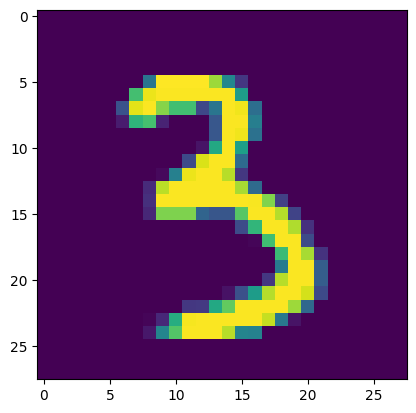

In [14]:

def test(test_index: int) -> None:
    
    img_arr = test_prepared_dataset[test_index]
    value = test_prepared_dataset_marks[test_index]

    correct_ans = np.argmax(value)
    img_expanded = np.expand_dims(img_arr, axis=0)
    plt.imshow(img_arr.reshape(28, 28))
    result = model.predict(img_expanded)
    # print('result => ' + str(result))
    # print(result)
    predicted_number = np.argmax(result[0])
    # if correct_ans != predicted_number:

    print(f"LOOKS LIKE THIS IS \"{predicted_number}\" NUMBER WITH \"{result[0][predicted_number]}\"%")
    print(f'IS ANSWER CORRECTNES => {correct_ans == predicted_number}, index => {test_index}')

test(32)